In [1]:
import open3d as o3d
import numpy as np
import copy
import time
import os
import sys

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

# Global registration
Both [ICP registration](../Basic/icp_registration.ipynb) and [Colored point cloud registration](colored_point_cloud_registration.ipynb) are known as local registration methods because they rely on a rough alignment as initialization. This tutorial shows another class of registration methods, known as **global** registration. This family of algorithms do not require an alignment for initialization. They usually produce less tight alignment results and are used as initialization of the local methods.

## Visualization
This helper function visualizes the transformed source point cloud together with the target point cloud:

In [2]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4559,
                                      front=[0.6452, -0.3036, -0.7011],
                                      lookat=[1.9892, 2.0208, 1.8945],
                                      up=[-0.2779, -0.9482, 0.1556])

## Extract geometric feature
We downsample the point cloud, estimate normals, then compute a FPFH feature for each point. The FPFH feature is a 33-dimensional vector that describes the local geometric property of a point. A nearest neighbor query in the 33-dimensinal space can return points with similar local geometric structures. See [\[Rasu2009\]](../reference.html#rasu2009) for details.

In [6]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

## Input
This code below reads a source point cloud and a target point cloud from two files. They are misaligned with an identity matrix as transformation.

In [7]:
def prepare_dataset(voxel_size):
    print(":: Load two point clouds and disturb initial pose.")
    source = o3d.io.read_point_cloud("../../test_data/ICP/cloud_bin_0.pcd")
    target = o3d.io.read_point_cloud("../../test_data/ICP/cloud_bin_1.pcd")
    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

:: Load two point clouds and disturb initial pose.


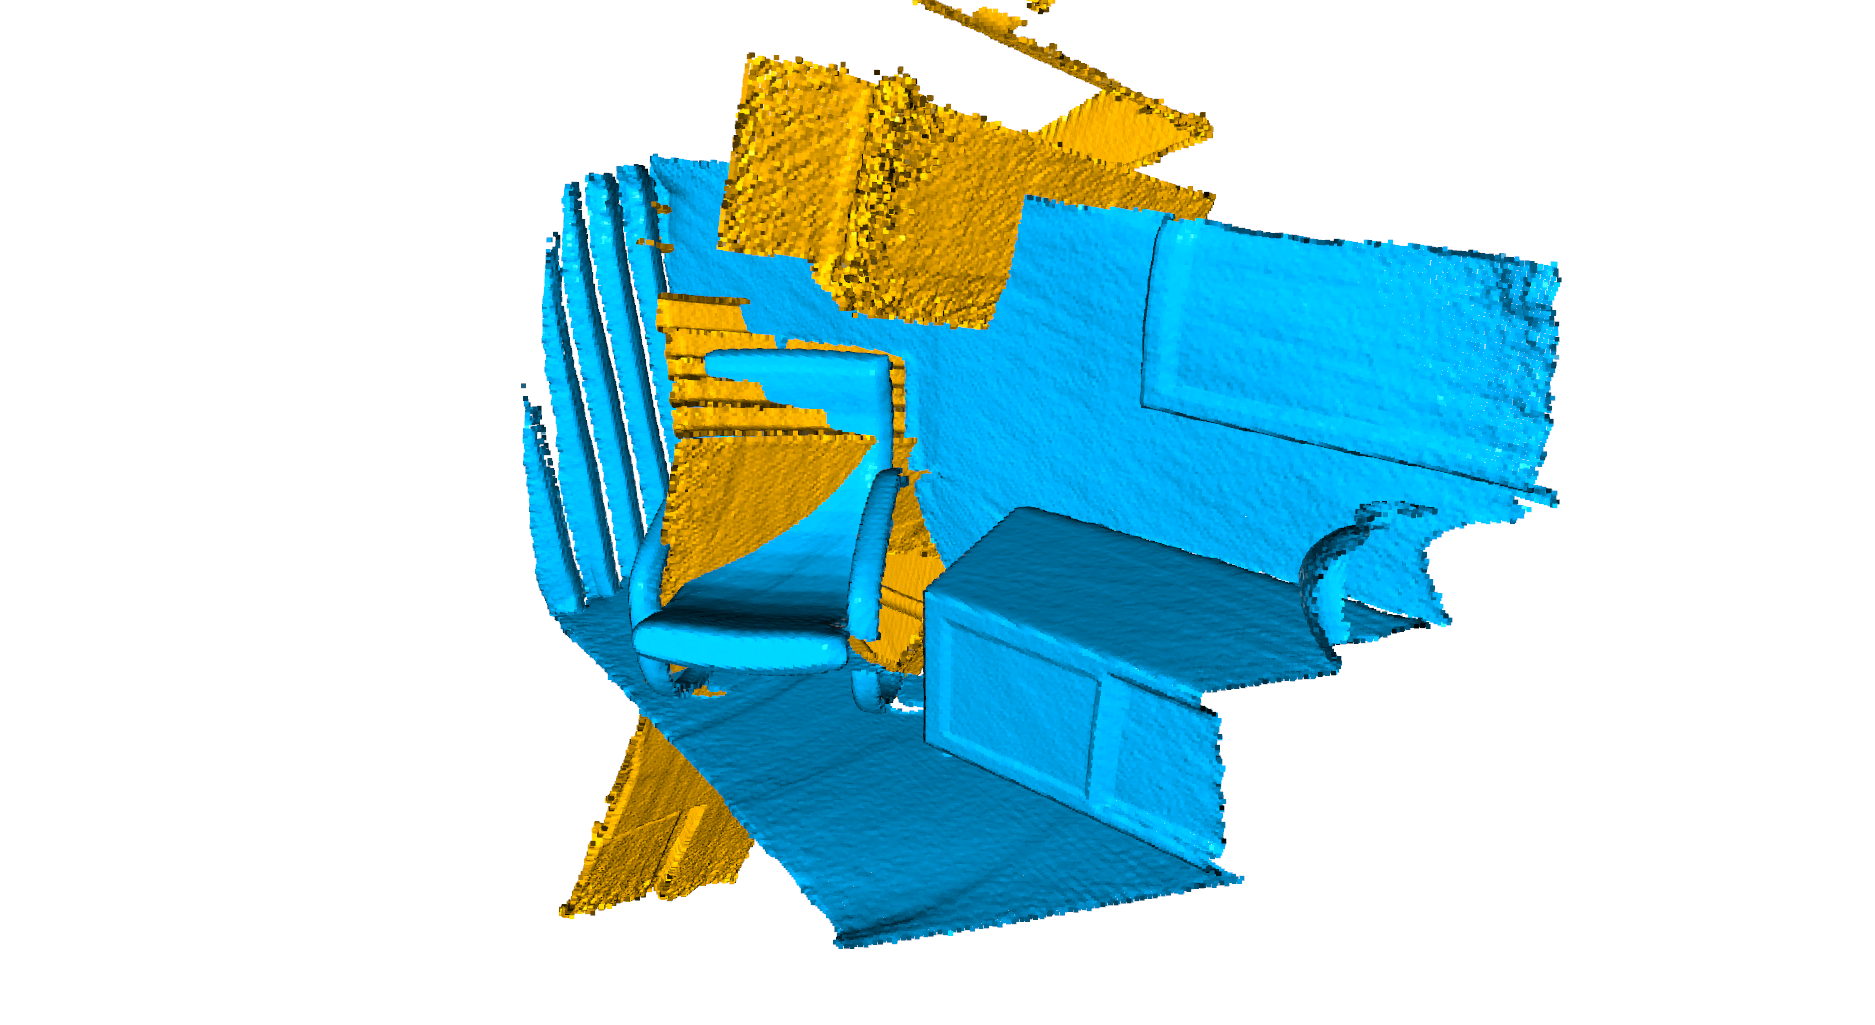

:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


In [8]:
voxel_size = 0.05  # means 5cm for this dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(
    voxel_size)

## RANSAC
We use RANSAC for global registration. In each RANSAC iteration, `ransac_n` random points are picked from the source point cloud. Their corresponding points in the target point cloud are detected by querying the nearest neighbor in the 33-dimensional FPFH feature space. A pruning step takes fast pruning algorithms to quickly reject false matches early.

Open3D provides the following pruning algorithms:

- `CorrespondenceCheckerBasedOnDistance` checks if aligned point clouds are close (less than the specified threshold).
- `CorrespondenceCheckerBasedOnEdgeLength` checks if the lengths of any two arbitrary edges (line formed by two vertices) individually drawn from source and target correspondences are similar. This tutorial checks that $||edge_{source}|| > 0.9 \cdot ||edge_{target}||$ and $||edge_{target}|| > 0.9 \cdot ||edge_{source}||$ are true.
- `CorrespondenceCheckerBasedOnNormal` considers vertex normal affinity of any correspondences. It computes the dot product of two normal vectors. It takes a radian value for the threshold.

Only matches that pass the pruning step are used to compute a transformation, which is validated on the entire point cloud. The core function is `registration_ransac_based_on_feature_matching`. The most important hyperparameter of this function is `RANSACConvergenceCriteria`. It defines the maximum number of RANSAC iterations and the maximum number of validation steps. The larger these two numbers are, the more accurate the result is, but also the more time the algorithm takes.

We set the RANSAC parameters based on the empirical value provided by [\[Choi2015]\](../reference.html#choi2015). 

In [10]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(":: RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, distance_threshold,
        o3d.registration.TransformationEstimationPointToPoint(False),
        4, [
            o3d.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.registration.RANSACConvergenceCriteria(4000000, 500))
    return result

:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
registration::RegistrationResult with fitness=6.771008e-01, inlier_rmse=2.906830e-02, and correspondence_set size of 3223
Access transformation to get result.


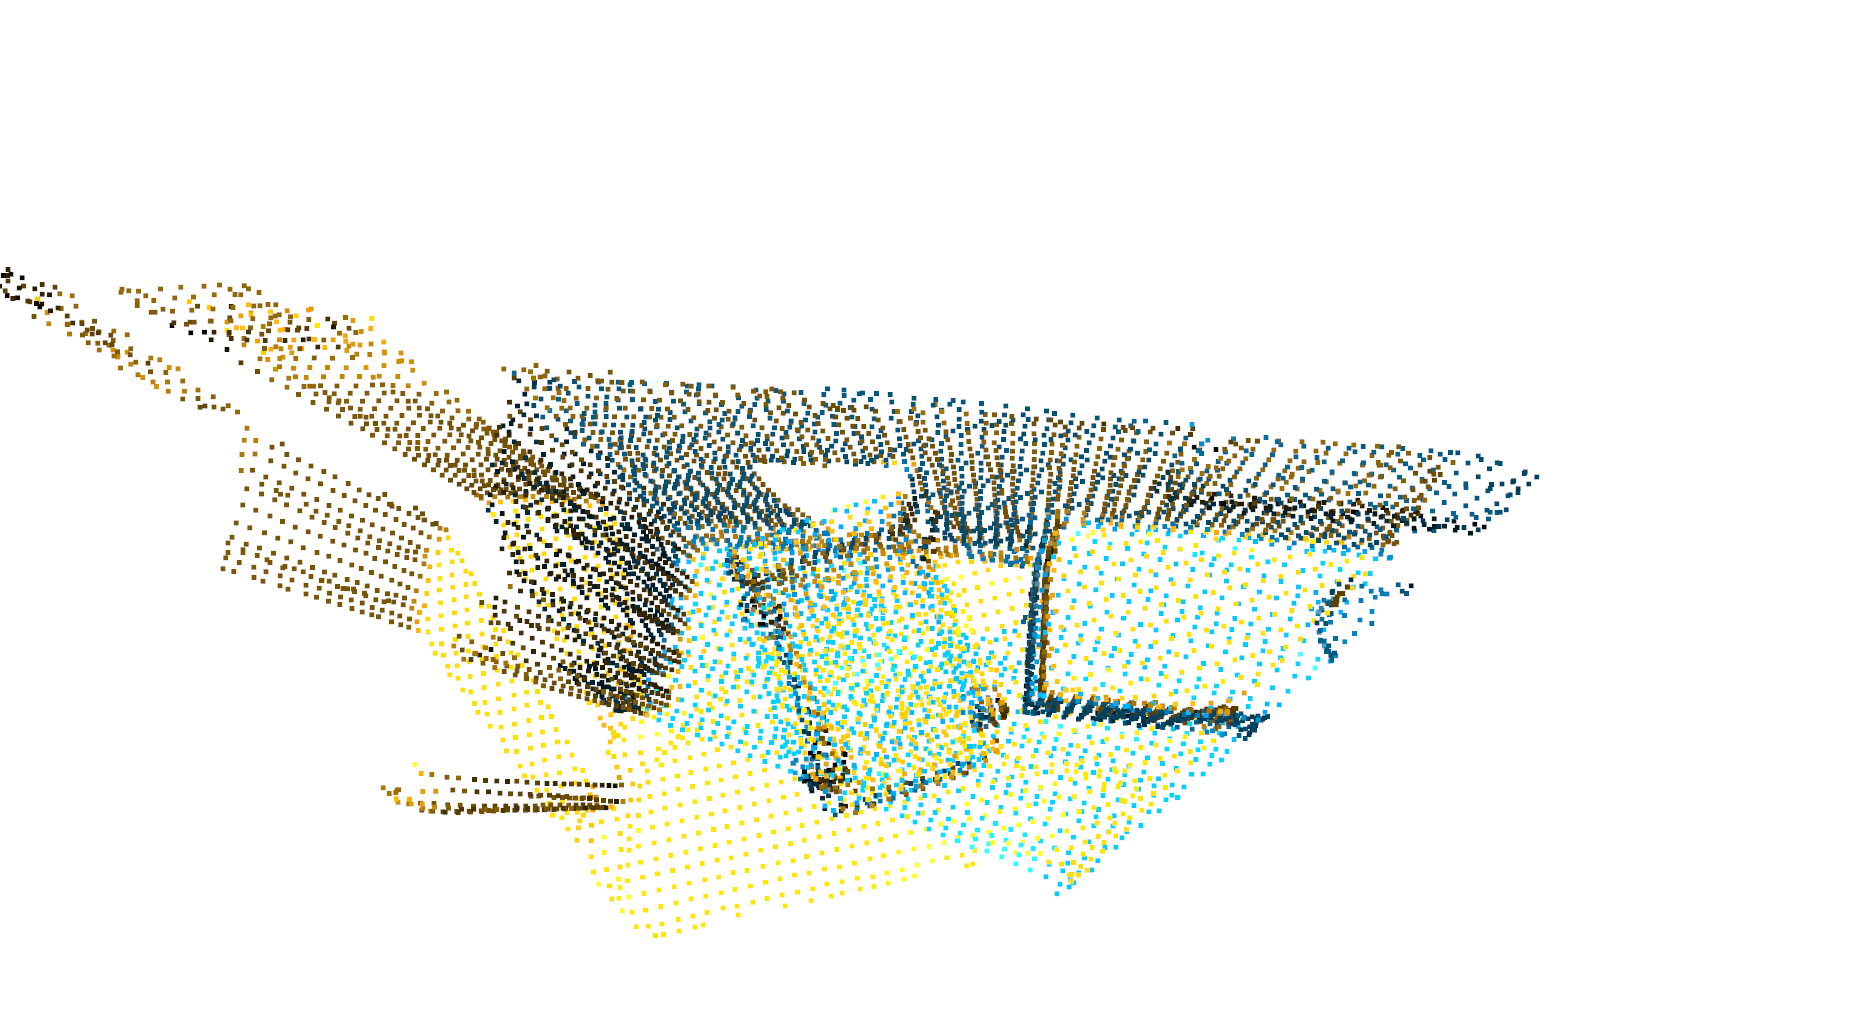

In [11]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)

<div class="alert alert-info">
    
**Note:**

Open3D provides a faster implementation for global registration. Please refer to [Fast global registration](#fast-global-registration).

</div>

## Local refinement
For performance reason, the global registration is only performed on a heavily down-sampled point cloud. The result is also not tight. We use [Point-to-plane ICP](../icp_registration.ipynb#point-to-plane-ICP) to further refine the alignment.

In [16]:
def refine_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = o3d.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.registration.TransformationEstimationPointToPlane())
    return result

:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.
registration::RegistrationResult with fitness=6.210275e-01, inlier_rmse=6.565172e-03, and correspondence_set size of 123482
Access transformation to get result.


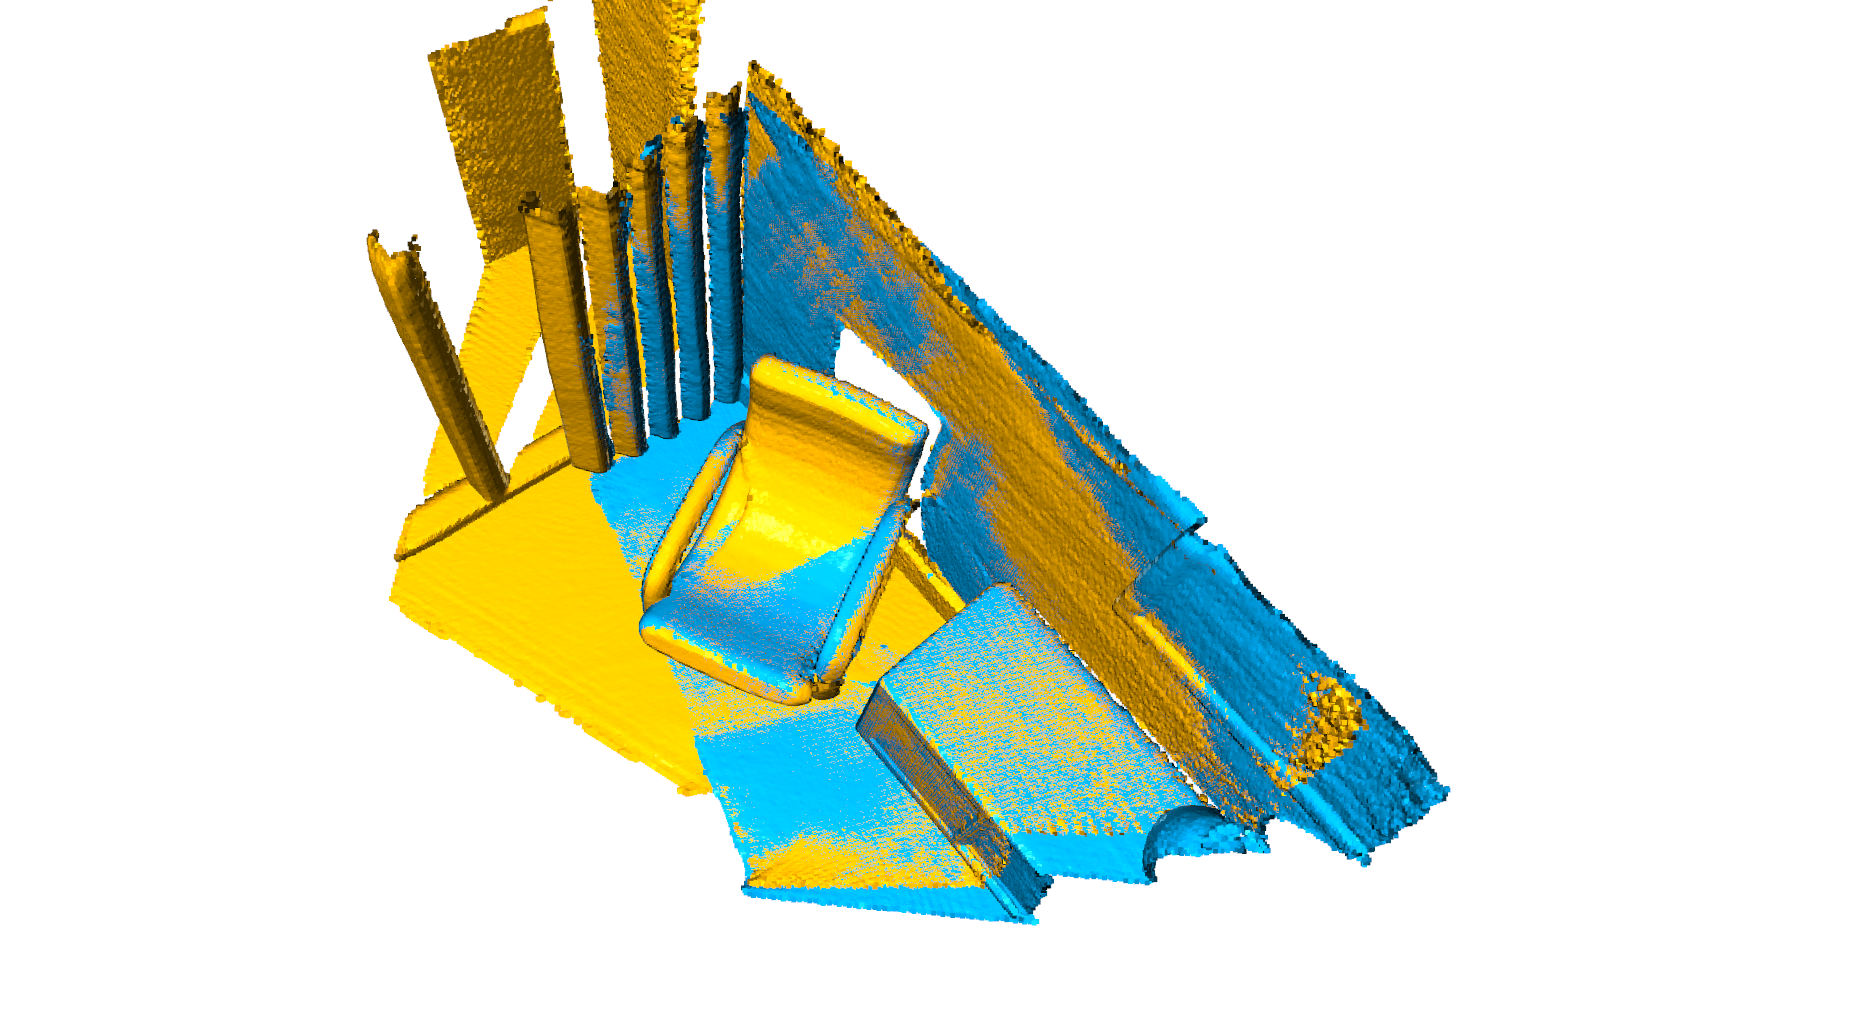

In [17]:
result_icp = refine_registration(source, target, source_fpfh, target_fpfh,
                                 voxel_size)
print(result_icp)
draw_registration_result(source, target, result_icp.transformation)

## Fast global registration
The RANSAC based global registration solution may take a long time due to countless model proposals and evaluations. [\[Zhou2016\]](../reference.html#zhou2016) introduced a faster approach that quickly optimizes line process weights of few correspondences. As there is no model proposal and evaluation involved for each iteration, the approach proposed in [\[Zhou2016\]](../reference.html#zhou2016) can save a lot of computational time.

This tutorial compares the running time of the RANSAC based global registration to the implementation of [\[Zhou2016\]](../reference.html#zhou2016).

### Input
We use the same input as in the global registration example above.

In [ ]:
voxel_size = 0.05  # means 5cm for the dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = \
        prepare_dataset(voxel_size)

### Baseline
In the code below we time the global registration approach.

In [ ]:
start = time.time()
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print("Global registration took %.3f sec.\n" % (time.time() - start))
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)

### Fast global registration
With the same input used for a baseline, the code below calls the implementation of [\[Zhou2016\]](../reference.html#zhou2016).

In [ ]:
def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    print(":: Apply fast global registration with distance threshold %.3f" \
            % distance_threshold)
    result = o3d.pipelines.registration.registration_fast_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

In [ ]:
start = time.time()
result_fast = execute_fast_global_registration(source_down, target_down,
                                               source_fpfh, target_fpfh,
                                               voxel_size)
print("Fast global registration took %.3f sec.\n" % (time.time() - start))
print(result_fast)
draw_registration_result(source_down, target_down, result_fast.transformation)

With proper configuration, the accuracy of fast global registration is even comparable to ICP. Please refer to [\[Zhou2016\]](../reference.html#zhou2016) for more experimental results.